# Bayes inference - Tensile tests example

<img src="./tensile_test.jpg" title="Tensile test of spruce wood specimen" style="width: 150px" align="center"/>

Tensile test data:
- $N$ tensile-test specimens
- $M_i$ stress-strain pairs are known for $i$-th specimen
- strain $\varepsilon_x$ is prescribed (explanatory variable)
 - we denote $e\equiv\varepsilon_x$ to prevent confusion with error term
 - $e_{ij}$ is the $j$-th prescribed strain on $i$-th specimen
- stress $s$ is measured (explained variable)
 - we denote $s\equiv\sigma_x$ to prevent confusion with standard deviation $\sigma$
 - $s_{ij}$ is the $j$-th measured stress on $i$-th specimen
 
## Goal
- Find distribution of stiffness (Young's modulus $E$) among specimens.
- Learn how certain is what we found considering inacurrate measurements and limited number of data.
 
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import os
import pymc3 as pm

# Directory containing .csv data files.
directory = "./example_data/"

# Find all *.csv files in given directory
paths = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            paths.append(os.path.join(root, file))
paths.sort()  # In-place sorting
#print(paths)

# Number of specimens = number of files
N = len(paths)
print('N = {}'.format(N))

N = 10


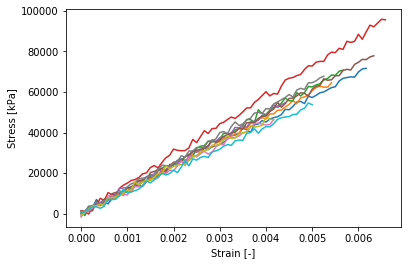

In [2]:
# Returns strains and stresses for i-th specimen.
def read_strain_stress_file(i):
    with open(paths[i]) as file:
        reader = csv.reader(file, delimiter=',')
        next(reader, None)  # skip the headers
        strain, stress = [], []
        for row in reader:
            strain.append(float(row[0]))
            stress.append(float(row[1]))
        return strain, stress


# Read strains and stresses for all specimens.
strain, stress = [], []
for i in range(N):
    e, s = read_strain_stress_file(i)
    strain.append(e)
    stress.append(s)

# Plot it    
plt.xlabel('Strain [-]')
plt.ylabel('Stress [kPa]')
for i in range(N):
    plt.plot(strain[i], stress[i])

In [3]:
M = [len(row) for row in strain]
print('M = {}'.format(M))

M = [75, 66, 69, 80, 54, 77, 51, 64, 51, 61]


# Probabilistic model

Explanatory variable
\begin{eqnarray}
e_{ij},\ i=1\dots N,\ j=1\dots M_i
\end{eqnarray}

Probabilistic model of measured data
\begin{eqnarray}
s_{ij} &\sim& \mathcal{N}(\mu = \bar{s}_{ij}, \sigma = \sigma_s)\\
\bar{s}_{ij} &=& E_i e_{ij}\\
E_i &\sim& \mathcal{N}(\mu = \mu_E, \sigma = \sigma_E)
\end{eqnarray}
where $x\sim\mathcal{N}(\mu, \sigma)$ means that $x$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

Prameters are $\sigma_s$, $\mu_E$ and $\sigma_E$. They need to have prior distribution specified 
\begin{eqnarray}
\sigma_s &\sim& \mathcal{U}(a,b)\\
\mu_E &\sim& \mathcal{U}(c,d)\\
\sigma_E &\sim& \mathcal{U}(e,f)\\
\end{eqnarray}
where $x\sim\mathcal{U}(a,b)$ means that $x$ is uniformly distributed between $a$ and $b$.

The prior distributions (the ranges in our case) are based on our current knowledge of the process.

# Posterior density

We utilize the [chain rule of probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)#More_than_two_random_variables).

\begin{eqnarray}
f(x_4, x_3, x_2, x_1) &=& f(x_4 \mid x_3, x_2, x_1) \cdot f(x_3, x_2, x_1) \\
&=& f(x_4 \mid x_3, x_2, x_1) \cdot f(x_3 \mid x_2, x_1) \cdot f(x_2, x_1) \\
&=& f(x_4 \mid x_3, x_2, x_1) \cdot f(x_3 \mid x_2, x_1)\cdot f(x_2 \mid x_1) \cdot f(x_1)
\end{eqnarray}

Posterior distribution of model parameters ("top level" parameters 
$\mu_E$, $\sigma_E$ and $\sigma_s$ and "other" parameters/latent variables $E_i$) given data. 
\begin{eqnarray}
&&f(\pmb{E}, \mu_E, \sigma_E, \sigma_s | \pmb{s})= \frac{f(\pmb{E}, \mu_E, \sigma_E, \sigma_s, \pmb{s})}{f(\pmb{s})} \propto f(\pmb{E}, \mu_E, \sigma_E, \sigma_s, \pmb{s})= \\
&&=f(\pmb{s}|\pmb{E}, \sigma_s)f(\pmb{E}|\mu_E,\sigma_E)f(\mu_E)f(\sigma_E)f(\sigma_s)= \\
&&\prod_{i=1}^{N}\prod_{j=1}^{M_i}f_N(s_{ij}, E_i \cdot e_{ij}, \sigma_s)\prod_{i=1}^{N}f_N(E_i, \mu_E, \sigma_E)f_U(\mu_E,c,d)f_U(\sigma_E,e,f)f_U(\sigma_s,a,b)
\end{eqnarray}
where
\begin{eqnarray}
f_N(x, \mu, \sigma) &=& \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{(x-\mu)^2}{2\sigma^2}\right)\\
f_U(x, a, b) &=&
\begin{cases}
\frac{1}{b-a}\quad\textrm{if}\,x\in\langle a,b \rangle\\
0 \quad \textrm{otherwise}
\end{cases}
\end{eqnarray}

We cerated function that is poroportinal to posterior joint PDF of model parameters. What do we do now? 

In [4]:
# Flattens list of lists
def flatten(lol): return [item for sublist in lol for item in sublist]

e_flat = flatten(strain)
s_flat = flatten(stress)
Mtot = sum(M)
ind = flatten([M[i] * [i] for i in range(N)])

print("Mtot = {}".format(Mtot))
print("ind = {}".format(ind))

Mtot = 648
ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [5]:
# Slicing 
A = np.array(['A', 'B', 'C'])
i = [2, 0, 1, 1, 1]
A[i]


array(['C', 'A', 'B', 'B', 'B'], dtype='<U1')

In [6]:
#-------------
# PyMC3 model
#-------------

pymc3_model = pm.Model()
with pymc3_model:
    # Prior
    mu_E = pm.Uniform('mu_E', 2.0, 20.0)  # GPa
    sigma_E = pm.Uniform('sigma_E', 0.01, 10.0)  # GPa
    sigma_s = pm.Uniform('sigma_s', 10.0, 10000.0)  # kPa
    # Parameters / 
    E = pm.Normal('E', mu=mu_E, sd=sigma_E, shape=N)  # GPa
    mu_s = 1e6 * E[ind] * e_flat  # kPa
    s_flat_obs = pm.Normal('s_flat_obs', mu=mu_s, sd=sigma_s, observed=s_flat)

# Sample from posterior
with pymc3_model:
    trace = pm.sample(2000, tune = 1000)
    #start={'muE':12.0, 'sE':1.0, 'sSigma':1000.0, 'E':(10*[12.0])}
    #start_v2 = {'muE':20.0, 'E':(10*[20.0])}
    #trace = pm.sample(10000, start=start_v2, tune=1000) # tune - Number of iterations to tune, defaults to 500.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [E, sigma_s, sigma_E, mu_E]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:12<00:00, 474.23draws/s]


In [7]:
print('mu_E = {}'.format(trace['mu_E']))
print('sigma_E = {}'.format(trace['sigma_E']))

mu_E = [12.88368317 12.42351705 11.40720632 ... 12.13066736 12.23282567
 11.3814878 ]
sigma_E = [1.16152841 1.59691992 1.20462251 ... 1.66713449 1.68835436 2.30824656]


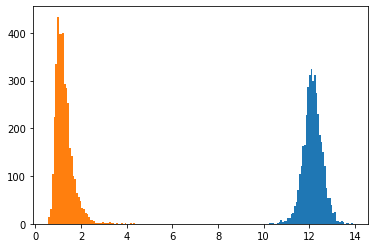

In [8]:
plt.hist(trace['mu_E'],bins=50);
plt.hist(trace['sigma_E'],bins=50);

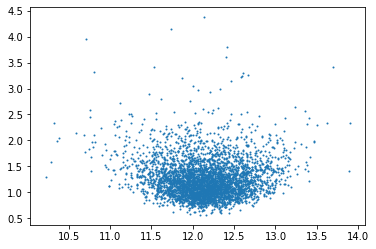

In [9]:
plt.scatter(trace['mu_E'],trace['sigma_E'],s=1);

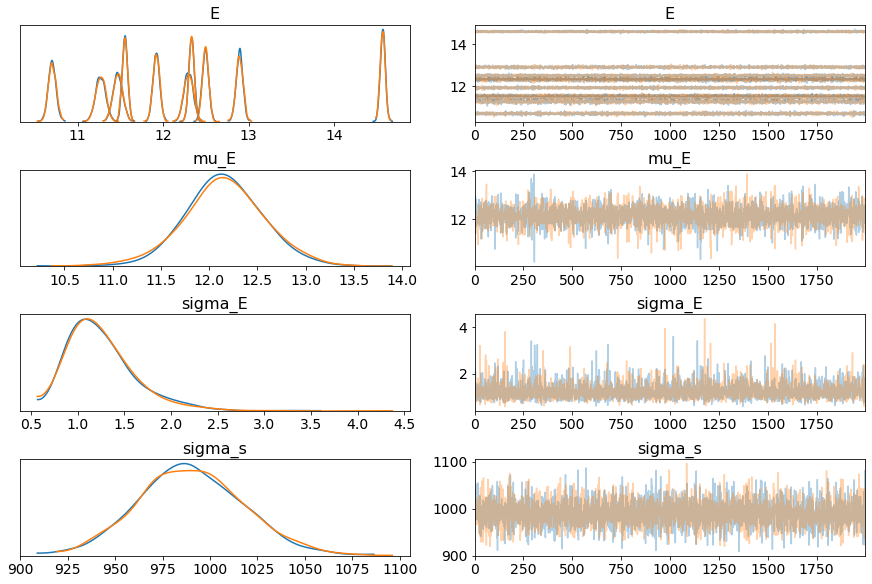

In [10]:
pm.traceplot(trace, compact=True); # Semicolon suppresses python's textual output.

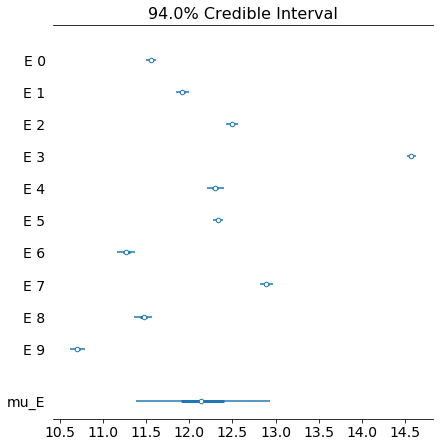

In [11]:
pm.forestplot(trace, var_names=["E", "mu_E"], combined=True);